In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import itertools
import matplotlib.pyplot as plt

In [6]:
df_train = pd.read_csv('Datasets/train.csv') # using pandas to read the test set
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [7]:
useless_cols = ['id','CustomerId','Surname']
df_train.drop(columns=useless_cols,inplace=True)
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [8]:
string_cols = ['Geography','Gender']
target = ['Exited']

df_train = pd.get_dummies(df_train,columns=string_cols,dtype=int)
df_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0,0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,0,0,1,1,0
165030,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,1,0,0,0,1
165031,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,1,0,0,0,1
165032,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0,0,1,1,0


In [9]:
df_train['Balance'] = df_train.Balance.apply(lambda x: 0 if x == 0 else 1)
df_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0,2,1.0,0.0,181449.97,0,1,0,0,0,1
1,627,33.0,1,0,2,1.0,1.0,49503.50,0,1,0,0,0,1
2,678,40.0,10,0,2,1.0,0.0,184866.69,0,1,0,0,0,1
3,581,34.0,2,1,1,1.0,1.0,84560.88,0,1,0,0,0,1
4,716,33.0,5,0,2,1.0,1.0,15068.83,0,0,0,1,0,1


In [10]:
X = df_train.drop(columns='Exited')
y = df_train.Exited

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [17]:
best_model = None
best_columns = None
best_accuracy = 0.0
all_columns = X.columns

models = {
    'CatBoost': CatBoostClassifier(eval_metric='AUC',verbose=False)
}

param_grids = {
    'CatBoost': {
    'learning_rate': [0.01, 0.1],
    'depth': [3, 5, 7],
    'iterations': [100, 300],
}
}

results = []
wanted_list = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Gender_Female']

for model_name, model in models.items():
    for r in range(1, len(all_columns) + 1):
        for columns_combination in itertools.combinations(all_columns, r):
            if not set(wanted_list).issubset(columns_combination):
                continue
            param_grid = param_grids[model_name]
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
            
            X_train_subset = X_train[list(columns_combination)]

            grid_search.fit(X_train_subset, y_train)

            best_params = grid_search.best_params_
            y_pred = grid_search.predict_proba(X_test[list(columns_combination)])[:,1]
            accuracy = roc_auc_score(y_test, y_pred)

            result = {
                'Model': model_name,
                'Columns': columns_combination,
                'Best_Params': best_params,
                'Test_Accuracy': accuracy
            }
            results.append(result)
            print(f'Finalizado el análisis de {model_name} con columnas {columns_combination}\n')
            print(result)

best_result = max(results, key=lambda x: x['Test_Accuracy'])
best_model = best_result['Model']
best_columns = best_result['Columns']
best_accuracy = best_result['Test_Accuracy']

print("Best Model:", best_model)
print("Best Columns:", best_columns)
print("Best Accuracy:", best_accuracy)


Finalizado el análisis de CatBoost con columnas ('CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Gender_Female')

{'Model': 'CatBoost', 'Columns': ('CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Gender_Female'), 'Best_Params': {'depth': 5, 'iterations': 300, 'learning_rate': 0.1}, 'Test_Accuracy': 0.8906747160488349}
Finalizado el análisis de CatBoost con columnas ('CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Gender_Female')

{'Model': 'CatBoost', 'Columns': ('CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Gender_Female'), 'Best_Params': {'depth': 5, 'iterations': 300, 'learning_rate': 0.1}, 'Test_Accuracy': 0.8908661825016103}
Finalizado el análisis de CatBoost con columnas ('CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiv

In [18]:
params_final = best_result['Best_Params']
print(best_columns)
print(params_final)

('CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Gender_Female')
{'depth': 5, 'iterations': 300, 'learning_rate': 0.1}


In [19]:
final_model = CatBoostClassifier(**params_final,eval_metric='AUC')
X_final = X[list(best_columns)]
y_final = y
final_model.fit(X_final,y_final)

0:	total: 25.9ms	remaining: 7.75s
1:	total: 49.7ms	remaining: 7.4s
2:	total: 63.3ms	remaining: 6.26s
3:	total: 74.3ms	remaining: 5.49s
4:	total: 83.3ms	remaining: 4.91s
5:	total: 91ms	remaining: 4.46s
6:	total: 99.6ms	remaining: 4.17s
7:	total: 108ms	remaining: 3.95s
8:	total: 116ms	remaining: 3.76s
9:	total: 125ms	remaining: 3.61s
10:	total: 134ms	remaining: 3.51s
11:	total: 142ms	remaining: 3.42s
12:	total: 152ms	remaining: 3.35s
13:	total: 161ms	remaining: 3.29s
14:	total: 170ms	remaining: 3.23s
15:	total: 178ms	remaining: 3.16s
16:	total: 187ms	remaining: 3.11s
17:	total: 196ms	remaining: 3.06s
18:	total: 203ms	remaining: 3s
19:	total: 212ms	remaining: 2.97s
20:	total: 220ms	remaining: 2.92s
21:	total: 228ms	remaining: 2.88s
22:	total: 237ms	remaining: 2.85s
23:	total: 246ms	remaining: 2.82s
24:	total: 255ms	remaining: 2.8s
25:	total: 264ms	remaining: 2.78s
26:	total: 273ms	remaining: 2.76s
27:	total: 281ms	remaining: 2.73s
28:	total: 290ms	remaining: 2.71s
29:	total: 298ms	remaini

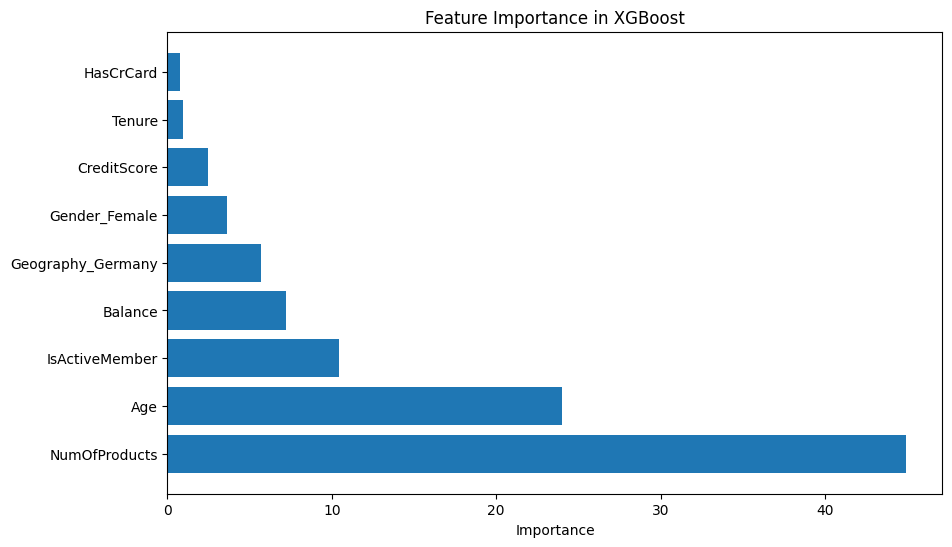

In [22]:
# Obtener la importancia de las características
feature_importance = final_model.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
feature_importance_df = pd.DataFrame({
    'Feature': best_columns,
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost')
plt.show()

In [23]:
df_test = pd.read_csv('Datasets/test.csv')

df_test

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,275055,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [24]:
df_test = pd.get_dummies(df_test,columns=string_cols,dtype=int)
df_test

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,165034,15773898,Lucchese,586,23.0,2,0.00,2,0.0,1.0,160976.75,1,0,0,1,0
1,165035,15782418,Nott,683,46.0,2,0.00,1,1.0,0.0,72549.27,1,0,0,1,0
2,165036,15807120,K?,656,34.0,7,0.00,2,1.0,0.0,138882.09,1,0,0,1,0
3,165037,15808905,O'Donnell,681,36.0,8,0.00,1,1.0,0.0,113931.57,1,0,0,0,1
4,165038,15607314,Higgins,752,38.0,10,121263.62,1,1.0,0.0,139431.00,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,29.0,7,116099.82,1,1.0,1.0,148087.62,0,0,1,0,1
110019,275053,15774133,Cox,575,36.0,4,178032.53,1,1.0,1.0,42181.68,1,0,0,1,0
110020,275054,15728456,Ch'iu,712,31.0,2,0.00,2,1.0,0.0,16287.38,1,0,0,0,1
110021,275055,15687541,Yegorova,709,32.0,3,0.00,1,1.0,1.0,158816.58,1,0,0,1,0


In [25]:
df_test['Balance'] = df_test.Balance.apply(lambda x: 0 if x == 0 else 1)
df_test.head(5)

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,165034,15773898,Lucchese,586,23.0,2,0,2,0.0,1.0,160976.75,1,0,0,1,0
1,165035,15782418,Nott,683,46.0,2,0,1,1.0,0.0,72549.27,1,0,0,1,0
2,165036,15807120,K?,656,34.0,7,0,2,1.0,0.0,138882.09,1,0,0,1,0
3,165037,15808905,O'Donnell,681,36.0,8,0,1,1.0,0.0,113931.57,1,0,0,0,1
4,165038,15607314,Higgins,752,38.0,10,1,1,1.0,0.0,139431.00,0,1,0,0,1


In [26]:
df_test.drop(columns=['CustomerId','Surname'],inplace=True)

In [27]:
X_final_test = df_test[list(best_columns)]
X_final_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Geography_Germany,Gender_Female
0,586,23.0,2,0,2,0.0,1.0,0,1
1,683,46.0,2,0,1,1.0,0.0,0,1
2,656,34.0,7,0,2,1.0,0.0,0,1
3,681,36.0,8,0,1,1.0,0.0,0,0
4,752,38.0,10,1,1,1.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...
110018,570,29.0,7,1,1,1.0,1.0,0,0
110019,575,36.0,4,1,1,1.0,1.0,0,1
110020,712,31.0,2,0,2,1.0,0.0,0,0
110021,709,32.0,3,0,1,1.0,1.0,0,1


In [28]:
predictions = final_model.predict_proba(X_final_test)[:,1]
predictions

array([0.02396117, 0.83828976, 0.02274817, ..., 0.0121466 , 0.14381802,
       0.21236037])

In [29]:
columna_id = df_test['id']
dictionario = {'id':columna_id,'Exited':predictions}
df_entrega = pd.DataFrame(dictionario)
df_entrega

,id,Exited
0,165034,0.023961
1,165035,0.838290
2,165036,0.022748
3,165037,0.239859
4,165038,0.346825
...,...,...
110018,275052,0.035708
110019,275053,0.086499
110020,275054,0.012147
110021,275055,0.143818


In [30]:
df_entrega.to_csv('Datasets/submission4.csv',index=False)

In [31]:
! kaggle competitions submit playground-series-s4e1 -f Datasets/submission4.csv -m "My Fifth submission"

Successfully submitted to Binary Classification with a Bank Churn Dataset 



  0%|          | 0.00/2.93M [00:00<?, ?B/s]
  1%|          | 16.0k/2.93M [00:00<01:31, 33.5kB/s]
 15%|█▌        | 464k/2.93M [00:00<00:02, 1.05MB/s] 
 28%|██▊       | 848k/2.93M [00:00<00:01, 1.73MB/s]
 39%|███▉      | 1.14M/2.93M [00:00<00:01, 1.80MB/s]
 57%|█████▋    | 1.66M/2.93M [00:00<00:00, 2.63MB/s]
 68%|██████▊   | 2.00M/2.93M [00:01<00:00, 1.94MB/s]
 77%|███████▋  | 2.27M/2.93M [00:01<00:00, 1.69MB/s]
 85%|████████▍ | 2.48M/2.93M [00:01<00:00, 1.54MB/s]
 91%|█████████ | 2.67M/2.93M [00:01<00:00, 1.46MB/s]
 97%|█████████▋| 2.84M/2.93M [00:01<00:00, 1.41MB/s]
100%|██████████| 2.93M/2.93M [00:03<00:00, 959kB/s] 
